# BDA Final Project
# Spotify Podcasts Analysis

Xavier Cucurull Salamero

December 2021

<center><img src='Docs/img/spotify_bda_logo.png'  width="500" ></center>



## 1. Introduction

Podcasts are an audio-only mean of communication that is rapidly growing. Spotify, one of the major audio streaming services has recently put more attention into podcasting. Last month the company expanded their Podcast Subscription program to global markets [1] and in their Q3 shareholder letter the company [2] pointed out that podcasts on Spotify are up to 3.2M from 2.9M the previous quarter, maintaining also a strong monthly active users engagement.

With the growth of podcasting, getting insights on the market evolution is crucial for many stakeholders. Podchaser, the "IMDb for podcasts", which provides payment services targeted at marketers, PR firms, and other professionals to get relevant insights and metrics, announced in January $4M in funding [3].

I am a podcast enthusiast and I have recently found myself consuming content that is only available online, as opposed to those podcasts that are also broadcast live on the radio, with some podcasts being Spotify exclusive. In addition, during the COVID-19 lockdown I had the impression that new podcasts were created every week, as if almost everybody wanted to make one. As a result, I thought that conducting an analysis on the podcast market could be really interesting and a good challenge to apply the knowledgee obtained during the course.

This project is divided in two parts. First, the development of a podcast scraper using the Spotify API [4] with the goal of constructing a database containing various information about the show such as name, publisher and release date. Second, a big data analysis on the obtained dataset, with the goal of getting insight on the evolution and current state of the podcast market. For simplicity, given the long processing time necessary to construct the database, the scope of the study has been narrowed down to podcasts in Catalan and Spanish, which are my two native languages.


## 2. Data collection
Being a Spotify user, I first searched for their API to see what could be done and I saw that last year Spotify introduced the podcasts API [5]. This seemed promising because compared to other services such as Podchaser, which has a limit of 25,000 monthly/requests on their free plan, Spotify desn't have any restrictions in terms of the total number of queries, only a quota related to the amount of requests that can be made in a 30 seconds window.

The main Spotify web API function is "Search", which allows to get catalog information about albums, artists, playlists, tracks, shows or episodes that match a keyword string. So in order to get a list of all the podcasts in the Spotify catalog it was necessary to find those keywords that would retrieve them. With the API limit of 1000 responses for request this seemed like an impossible task. How could I think of those words or strings that would lead me to discover the titles of all the podcasts available? Before using the Spotify API to get information about the shows I needed to find a list of podcast names. To do that I thought of another podcast provider, Apple's iTunes [6]. Being part of the Apple Developer Program costs $99 [7], which is not affordable for the scope of this project. Since I just needed to get a list of the names of all the podcasts available on the iTunes catalog, I could write a simple Python script to perform the web scraping. Once I got this list, I could search for each of the names using the Spotify API. Below there is a diagram of the database creation process.

<center><figure>
    <img src='Docs/img/database_creation_diagram.png' width="450">
    <figcaption><i>Fig 1. Database creation diagram<i><figcaption>
<figure></center>
        

### 2.1. Apple Podcasts scraper
The first part of the database construction is the Apple Podcasts scraper. This Python script uses the ```requests``` and ```beautifulsoup``` packages to parse the html files of the Apple Podcasts page, exploring all the different categories, and creates a CSV table with the title and genre of all the podcasts in the catalog.

Since the podcast shows are sorted by genre, the first step is to get all the genres and their corresponding url. Figure 2 shows the rendred website and the html code of the iTunes Podcast genres page.

<center><figure>
    <img src='Docs/img/apple_podcasts_website.png' width="750">
    <figcaption><i>Fig 2. iTunes Podcasts website - Genres<i><figcaption>
<figure></center>   

        
Next, for each of the genres, the script iterates over all the pages that exist for each of the letters, as podcasts pages are organized and sorted alphabetically. Figure 3 shows the podcasts page for the genre "Arte".
        
<center><figure>
    <img src='Docs/img/apple_podcasts_selectedgenre.png' width="750">
    <figcaption><i>Fig 3. iTunes Podcasts website - Shows<i><figcaption>
<figure></center> 

The following code snippet, adapted from the ```get_podcasts_from_page``` function from the ```apple_podcats_scraper.py``` script, shows how a list of podcast titles can be obtained given the genre url, an alphabet letter and a page.

        
```python
url = f'{genre_url}?letter={letter}&page={page}'
response = requests.get(url)

soup = BeautifulSoup(response.text, 'html.parser')
selected_genre = soup.find(id='selectedgenre')
podcasts = selected_genre.find(id='selectedcontent').find_all('li')

podcasts_list.extend([p.get_text().rstrip() for p in podcasts])

```

Scraping content from the Apple iTunes Podcast webpage is a relatively simple process, since not a very high number of requests need to be made. As a result, the whole process was executed in 52 minutes, obtaining a final list of 2,056,848 podcasts. Below there's an extract of the debug messages printed by the ```apple_podcats_scraper.py``` script.
        
```
[12:36:45] Starting podcast scraping...
[12:36:45] Retrieving "Arte" podcasts...
	Letter A: 15360 podcasts (64 pages)
	Letter B: 11760 podcasts (49 pages)
	Letter C: 15600 podcasts (65 pages)
	Letter D: 10320 podcasts (43 pages)
	Letter E: 7440 podcasts (31 pages)
	Letter F: 7440 podcasts (31 pages)
	Letter G: 5760 podcasts (24 pages)
	Letter H: 7440 podcasts (31 pages)
	Letter I: 6000 podcasts (25 pages)
```

### 2.2. Spotify Podcasts scraper
        
The second and most important part of the database construction is the Spotify Podcast scraper. Using the list of Apple podcasts and Spotipy, which is a Python library for the Spotify Web API, this script iterates over each of the titles on the previously obtained podcast list and uses the search function to get those shows that match the provided string. Since some titles availabe in the Apple podcast list might not be present in the Spotify catalog and vice-versa, for each given title a maximum (configurable) number of 10 shows are retrieved. This allows for more "exploration" of the Spotify catalog, being able to discover shows that were not present in the original podcasts list. When searching for a show, the Spotify API returns information about the **id**, the **name**, the **description**, the **publisher**, the **total number of episodes**, whether it is flagged as **explicit**, the **languages** and **media type**. In order to obtain information about the release date and the date of the last show, the next step is to retrieve the episodes corresponding to each of the show. Since getting episode information adds a lot of overhead to the database creation process, at this step shows with languages Catalan ("ca") or Spanish ("es) are filtered. In addition, in order to reduce the number of API calls, only a maximum number of 100 episodes (containing the first and the last) are retrieved. With those episodes, we obtain the **release date** of the show, the **last date** of the newest episode and the **average duration** of the episodes. Finally, the show is added to the database. Since the show id is used as a unique id in the database, the addition of duplicate entries is avoided.

The process of scraping the Spotify catalog to create the podcasts database has been remarkably more complicated than obtaining the Apple podcast list. In order to avoid timeout errors, the Spotipy client has been configured with a high request timeout of 60 and the number of retries have also been increased to 10. In addition to that, a wait-retry strategy has also been implemented in order to overcome bad responses.

The Apple podcasts list (```data/apple_podcasts.csv```) has a size of 76MB, so loading all its content in memory is perfecly feasible. However, in order to replicate a real-world scenario where the file to read is too big to read in memory, it is read in batches. In addition, in order to speed up the scraping process, the shows are retrieved in parallel using Python's ```multiprocessing```. Podcasts title are read in batches of 1000 and then processed. This batch approach also allows to stop the scraping process and start it later on, by indicating an *offset* so that a number of batches are skipped. This proved to be very useful since the process was sometimes interrupted due to connection problems or because the computer froze. 
        
The ```SpotifyScraper``` class has been implemented in ```spotify_podcasts_scraper.py``` and the script that retrieves the shows and episode information and constructs the database is ```build_database.py```. Below there's an extract of the debug messages printed by the ```build_database.py``` script.
        
```
[14:03:50] Processing batch 1478. 579 remaining...
[14:05:48] 1034 shows retrieved from batch of 1000

[14:05:48] Processing batch 1479. 578 remaining...
Spotipy search error! Retrying in 30s...
[14:09:40] 690 shows retrieved from batch of 1000

```
The number of shows retrieved correspond to those shows that are in Spanish or Catalan. Notice that it is possible than more than 1000 shows are retrieved from the batch because of the "exploration" mentioned above.

T
After the whole building process, which has taken 3 days and 23:18:52, a database with 263,202
        
 
### 2.3. MongoDB database
Given the relative simplicity of the database to create and because of the fact that only one database -the podcasts database- is needed, MongoDB has been chosen for the project. 

The same docker container as the one used in Lab03 has been used. It is created by opening a terminal and running the following command:
```docker run --name bda-mongo -e MONGO_INITDB_ROOT_USERNAME=mongoadmin -e MONGO_INITDB_ROOT_PASSWORD=pass1234 -d -p 27017:27017 mongo```
        
Once the container is running, the Python script connects to it and creates a database called ```finalproject``` and a collection with the name ```podcasts```, where the podcasts are stored. As learned in Lab03, Compass can be used to access the database using a graphical user interface. In addition, by connecting to the computer's IP and port it can even be accessed from another computer. In my case, I used a desktop computer running Ubuntu 20.04 to construct the database but I also monitored it using Compass on a laptop running macOS.

<center><figure>
    <img src='Docs/img/compass.png' width="750">
    <figcaption><i>Fig 4. MongoDB Compass<i><figcaption>
<figure></center> 


### 2.4. Limitations
This method, although effective to build a big dataset that is representative of the podcasts market, has some limitations. First of all, although most podcasters try to have their show in platforms such as iTunes or Spotify, that is not always the case. In addition, with Spotify's increasing interest in podcasting, there are nowadays shows that are exclusive to Spotify. The titles of these shows don't appear on the Apple Podcasts list and, as a result, might be missed when scraping Spotify. One example is the podcast "Oye Polo", from Radio Primavera Sound, which was not captured by the database constructing method. 

### 2.5. Code Documentation
All the Python scripts developed in this project have been documented using Docstrings and the corresponding documentation has been generated using Sphinx. As a reference, the documentation of all the code related to the database construction process can be found in the ```Docs/build/html``` directory or [here](Docs/build/html/py-modindex.html).

## 3. Data description
In this section I will present the different fields of the documents of the database. I will use as an illustrative example the show "Gent de Merda", as shown in Compass.

<center><figure>
    <img src='Docs/img/compass_gentdemerda.png' width="550">
    <figcaption><i>Fig 5. Document example in Compass<i><figcaption>
<figure></center> 
        
Fields description:
        
- **_id**: MongoDB document identifier (ObjectId)
        
- **name**: Podcast name (string)
        
- **publisher**: Podcast publisher (string)
        
- **explicit**: Explicit content (boolean)
        
- **media_type**: Type of content (string)
        
- **id**: Spotify show ID (string)
        
- **languages**: A list of the languages used in the show, identified by their ISO 639 code (list of strings)
        
- **description**: Podcast description (string)
        
- **total_episodes**: Total number of episodes (int)
        
- **average_duration_min**: Average episode duration in minutes (int)
        
- **release_date**: Publishing date of the first episode
    - *year*: (int)
    - *month*: (int)
    - *day*: (int)
        
- **last_date**: Publishing date of the last episode
    - *year*: (int)
    - *month*: (int)
    - *day*: (int)
        
- **date_precision**: The precision with which the dates are known (string)


## 4. Data preprocessing

Data preprocessing is an important step of the whole big data analysis process. It is important to identify and clean possible errors regarding missing values, outliers, etc. In our case, since all the data has been obtained using the Spotify API, it is not very likely that we will find a lot of noise or errors in the data. However, since the goal of the project is to study the podcasts market, it might be important to identify those shows which don't provide any significant information. For example, that would be podcasts without any episodes or with episodes of a duration of just seconds.

From now on, all the programming will take place in this Jupyter Notebook, using PyMongo to connect to the podcasts MongoDB database.

### 4.1. Connect to the database
First, we connect to the MongoDB database:

In [1]:
import pymongo
from pprint import pprint

# Connect to the MongoDB
client = pymongo.MongoClient('localhost', 27017, username='mongoadmin', password='pass1234')

# Get already created database
database = client['finalproject']

# Get podcasts collections
podcasts = database.podcasts

In [2]:
# Show total number of podcasts in the database
total_num_podcasts = podcasts.count_documents({})
print(total_num_podcasts)

263202


Since I want to leave the original database intact, I will copy the ```podcasts``` collection and make all the changes on this duplicate.

In [3]:
# Copy "podcasts" to "podcasts_preprocessed"
pipeline = [ {"$match": {}}, 
             {"$out": "podcasts_preprocessed"},
           ]

podcasts.aggregate(pipeline)

# Check size of new collection
podcasts_prep = database.podcasts_preprocessed
total_num_podcasts_prep = podcasts_prep.count_documents({})
print(total_num_podcasts)

263202


### 4.2. Missing values
Missing values shall be specified as ```null``` in MongoDB. In pymongo these ```null``` values are interpreted as ```None``` so in our case, to find missing values using Python we will query for ```None``` values.

As mentioned in section 3, some cases of ```null``` values appear when a podcast has no episodes. For those episodes where the number of ```total_episodes``` is 0, the ```average_duration_min```, ```release_date``` and ```last_date``` have ```null``` values.

In [4]:
# Show None values of show with 0 episodes
num_shows_0_ep = podcasts_prep.count_documents({'total_episodes': 0})
example = podcasts_prep.find_one({'total_episodes': 0}, {'name': 1, 'release_date' : 1, 'last_date': 1, 'average_duration_min' : 1})

print(f'There are {num_shows_0_ep} shows ({num_shows_0_ep/total_num_podcasts_prep:.5f}%) with 0 episodes.\n\nExample:')
pprint(example)

There are 129 shows (0.00049%) with 0 episodes.

Example:
{'_id': ObjectId('61b276d16015f8bce7c4ea04'),
 'average_duration_min': None,
 'last_date': {'day': None, 'month': None, 'year': None},
 'name': 'KAIJUDEPU!',
 'release_date': {'day': None, 'month': None, 'year': None}}


The number of shows with a number of zero episodes is neglectable compared to the total number of shows that the database contains. However, since they don't give important information for our analysis, they can be removed from the database so as to have cleaner data from which to continue the analysis.

In [5]:
# Remove shows with 0 episodes
res = podcasts_prep.delete_many({'total_episodes': 0})
print(f'{res.deleted_count} documents deleted')

129 documents deleted


Let's see if there are still podcasts with missing values in their date related fields.

In [6]:
podcasts_prep.count_documents({'date_precision':None})

19

In [7]:
podcasts_prep.count_documents({'release_date.year':None})

19

In [8]:
podcasts_prep.find({'date_precision':None}).distinct('total_episodes')

[1]

In [9]:
podcasts_prep.find_one({'release_date.year':None})


{'_id': ObjectId('61b279066015f8bce7c4f1a0'),
 'name': 'Alto Parlante',
 'publisher': 'MisPodcasts.com',
 'explicit': False,
 'media_type': 'audio',
 'id': '4mQVP2o3DvRJZRa54Os0gz',
 'languages': ['es'],
 'description': 'Todo lo que me llamó la atención en el pasado y lo que me moviliza en el presente. El rock, la radio, los libros, el cine… la vida que me hizo un locutor.',
 'total_episodes': 1,
 'average_duration_min': None,
 'release_date': {'year': None, 'month': None, 'day': None},
 'last_date': {'year': None, 'month': None, 'day': None},
 'date_precision': None}

It seems that there are shows with more 1 episode that have missing values on the dates. That's a bit strange. If we use the ```id``` of the previous example and go to the website https://open.spotify.com/show/4mQVP2o3DvRJZRa54Os0gz we see that the podcast doesn't have any episodes. Erroneously, the Spotify API has returned 1 for the ```total_episodes``` when the show in fact has none. These podcasts should be removed too.

In [10]:
# Remove shows with no dates (actually 0 episodes)
res = podcasts_prep.delete_many({'date_precision':None})
print(f'{res.deleted_count} documents deleted')

19 documents deleted


### 4.3. Outliers

Appart from removing those podcasts which don't have any episodes, it is also important to analayze if there are any outliers that shall be removed.

Let's start by looking at the duration of the episodes.

``` python

# Grouped by occupation
pipeline = [
        {'$match': {'$and': [
                            {'education.num': {'$gte': 10}},
                            {'work.occupation': {'$ne': 'Tech_support'}},
                            {'work.occupation': {'$ne': 'Sales'}},
                            {'work.occupation': {'$ne': 'Exec_managerial'}},
                            {'work.occupation': {'$ne': 'Prof_specialty'}},
                            {'work.occupation': {'$ne': 'Adm_clerical'}},
                            {'work.occupation': {'$ne': None}}
                            ]}},
        { "$group": {
            "_id": {"occupation": "$work.occupation"},
            "count": { "$sum": 1 }
        }},
    
        {"$sort": SON([("count", pymongo.DESCENDING)])}    
]
```

In [11]:
# Min and Max average episode durations (greater than 0)
pipeline = [
            {"$match": {'average_duration_min': {'$gt': 0}}},
            {"$group": {
                  "_id": None,
                  "MaximumValue": { "$max": "$average_duration_min" },
                  "MinimumValue": { "$min": "$average_duration_min" }
            }}
]

c = podcasts_prep.aggregate(pipeline)
print(list(c)[0])

{'_id': None, 'MaximumValue': 690.43, 'MinimumValue': 0.01}


As seen above, the range of duration in minutes spans from just a second to more than 11 hours. A podcast episode of just some seconds is difficult to really be considered a valid show. Let's further analyse shows with a very low average episode duration.

In [12]:
# Podcasts with an average duration of less than 30 seconds
n_lt_30s = podcasts_prep.count_documents({'average_duration_min': {'$lt': 0.5}})

print(f'There are {n_lt_30s} ({n_lt_30s/total_num_podcasts_prep:.4f}%) podcasts with an average episode duration lower than 30 seconds')

There are 6131 (0.0233%) podcasts with an average episode duration lower than 30 seconds


Although compared to the total number of podcasts the number of podcasts with a (very) low average duration is not very high, it is still curious to see that the number is more than 5,000. Let's now look at how many of these podcasts have more than one or two episode.

In [13]:
# AND total episodes more than...
n_lt30_gt1 = podcasts_prep.count_documents({'$and': [
                            {'average_duration_min': {'$lt': 0.5}},
                            {'total_episodes': {'$gt': 1}}
                            ]})

n_lt30_gt2 = podcasts_prep.count_documents({'$and': [
                            {'average_duration_min': {'$lt': 0.5}},
                            {'total_episodes': {'$gt': 2}}
                            ]})

print(f'There are {n_lt30_gt1} ({n_lt30_gt1/n_lt_30s:.2f}%) podcasts with an average episode duration lower than 10 seconds that have more than one episode')
print(f'There are {n_lt30_gt2} ({n_lt30_gt2/n_lt_30s:.2f}%) podcasts with an average episode duration lower than 10 seconds that have more than two episodes')
# n_lt60_gt5

There are 590 (0.10%) podcasts with an average episode duration lower than 10 seconds that have more than one episode
There are 188 (0.03%) podcasts with an average episode duration lower than 10 seconds that have more than two episodes


From all the podcasts with an average epidose duration lower than 30 seconds, only a small fraction have more than one or two episodes.

We can consider that the shows with a short average episode duration are outliers that will not provide insightful information for our analysis. Therefore, we can also remove them.

In [14]:
# Remove shows with average duration lower than 30s
res = podcasts_prep.delete_many({'average_duration_min': {'$lt': 0.5}})

print(f'{res.deleted_count} documents deleted')

6131 documents deleted


In [15]:
c = podcasts_prep.aggregate([
   { "$group": {
      "_id": None,
      "Min avergage duration (minutes)": { "$min": "$average_duration_min" },
      "Max avergage duration (minutes)": { "$max": "$average_duration_min" }
   }}
])

print(list(c)[0])

{'_id': None, 'Min avergage duration (minutes)': 0.5, 'Max avergage duration (minutes)': 690.43}


Now the minimum average episode duration is 30 seconds.

### 4.4 Duplicates
The last preprocessing and data cleaning step is to find if the database contains any duplicate records. During the database creationg process it has been assured that the same podcast (with its unique Spotify ID) is not added more than once. However, it might be possible that the Spotify catalog contains duplicate shows that have in turn been added to our database.

In [16]:
# Find podcasts with the same name
c = podcasts_prep.aggregate(
    [
        {"$group": {"_id": "$name", "publisher": {"$addToSet": "$publisher"}, "count": {"$sum": 1}}},
        {"$match": {"count": { "$gt": 1 }}},
        {"$count": "totalCount"}
    ]
)
print(f'There are {list(c)[0]["totalCount"]} podcasts with duplicate names.')

# Example
c = podcasts_prep.aggregate(
    [
        {"$group": {"_id": "$name", "publisher": {"$addToSet": "$publisher"}, "count": {"$sum": 1}}},
        {"$match": {"count": { "$gt": 1 }, "_id": "Narraciones"}}
    ]
)
print(f'\nExample:\n {list(c)[0]}')

There are 8203 podcasts with duplicate names.

Example:
 {'_id': 'Narraciones', 'publisher': ['Mictlanteca', 'Ale Sanz', 'El Mundo Inteligible'], 'count': 3}


We can see in the example above that there are three shows with the name _"Narraciones"_. However, the publishers are different, so they are most probably different shows.


In [17]:
# Find podcasts with the same name and publisher
c = podcasts_prep.aggregate(
    [
        {"$group": {"_id": {"name": "$name", "publisher": "$publisher"}, "total_episodes": {"$addToSet": "$total_episodes"}, "count": {"$sum": 1}}},
        {"$match": {"count": { "$gt": 1 }}},
        { "$count": "totalCount"}
    ]
)
print(f'There are {list(c)[0]["totalCount"]} podcasts with duplicate name and publisher.')

# Example
c = podcasts_prep.aggregate(
    [
        {"$group": {"_id": {"name": "$name", "publisher": "$publisher"}, "total_episodes": {"$addToSet": "$total_episodes"}, "count": {"$sum": 1}}},
        {"$match": {"count": { "$gt": 1 }, "_id": {"name": "La Trinchera", "publisher": "La Trinchera"}}}
    ]
)
print(f'\nExample:\n {list(c)[0]}')

There are 1412 podcasts with duplicate name and publisher.

Example:
 {'_id': {'name': 'La Trinchera', 'publisher': 'La Trinchera'}, 'total_episodes': [4, 10], 'count': 2}


As expected, the number of shows with the same name and publisher is just a fraction of the number of podcasts with the same name. In the example above, we see that there are two shows with the same name and publisher but with different number of episodes. Since we have access to the origin of the data (Spotify) we can search for these two podcasts to see how different or similar they are. By looking at Spotify we can see that both podcasts are completely different.

In [18]:
# Find podcasts with the same name, publisher, number of episodes and release year
# addToSet document id, to use later for removal
c = podcasts_prep.aggregate(
    [
        {"$group": {"_id": {"name": "$name", "publisher": "$publisher", "episodes": "$total_episodes", "release_year": "$release_date.year"},
                    "count": {"$sum": 1}}},
        {"$match": {"count": { "$gt": 1 }}},
        { "$count": "totalCount"}
    ]
)

print(f'There are {list(c)[0]["totalCount"]} podcasts with duplicate name, publisher and number of episodes')

There are 834 podcasts with duplicate name, publisher and number of episodes


Podcasts that have the same _name_, _publisher_, _total_episodes_ and _release_date.year_ can be considered to be duplicated. To clean the database, duplicate podcasts are removed and only one document for each show is kept.

In [19]:
# Find podcasts with the same name, publisher, number of episodes and release year
# addToSet document id, to use later for removal
c = podcasts_prep.aggregate(
    [
        {"$group": {"_id": {"name": "$name", "publisher": "$publisher", "episodes": "$total_episodes", "release_year": "$release_date.year"},
                    "id": {"$addToSet": "$_id"}, "count": {"$sum": 1}}},
        {"$match": {"count": { "$gt": 1 }}}
    ]
)

# Remove duplicates
ids_to_remove = []

for doc in c:
    ids_to_remove.extend(doc['id'][1:])    # keep one id, remove rest
    
res = podcasts_prep.delete_many({"_id": {"$in": ids_to_remove}})
print(f'{res.deleted_count} documents deleted')

878 documents deleted


## 5. Data analysis
After cleaning the database by removing duplicate shows and podcasts that don't contain relevant information, that is, shows without episodes or with an average episode duration of just seconds, we can proceed with the data analaysis.

In [120]:
# Use Matplotlib and Seaborn for visualization
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set(font_scale=1.2)

### 5.1. Exploratory Data Analysis

First of all we will visualize each of the variables, both numerical and categorical, to start to get a sense of the dataset.
(means, medians, quantiles, histograms, boxplots
• You should always look at every variable - you will learn something!)

In [123]:
def categorical_count(collection, field):
    labels = []
    counts = []
    
    res = collection.aggregate([{'$group': {'_id': f'${field}', 'count': {'$sum': 1}}}])

    for sample in res:
        labels.append(str(sample['_id']))
        counts.append(sample['count'])

    return labels, counts

def plot_count(collection, field):
    labels, counts = categorical_count(collection, field)
    
    figure(figsize=(8, 5))
    sns.barplot(x=labels, y=counts)
    plt.xlabel(field)
    plt.ylabel("Number of Podcasts");


#### 5.1.1 Categorical Variables

In [ ]:
# Languages
labels, counts = categorical_count(podcasts_prep, 'languages')



# sns.barplot(labels, counts)
# plt.xlabel("Target  ->")
# plt.ylabel("Frequency  ->");

# plt.bar([1, 2], counts)
# plt.show()

labels

["['es']", "['ca']"]

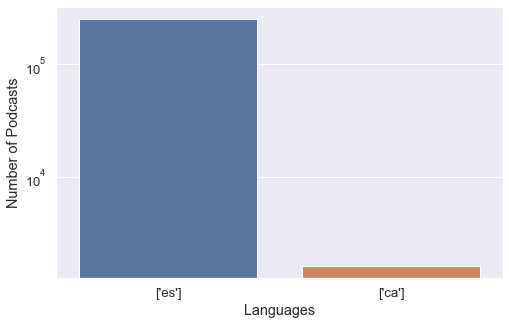

In [125]:
figure(figsize=(8, 5))
sns.barplot(x=labels, y=counts)
plt.yscale('log')
plt.xlabel("Languages")
plt.ylabel("Number of Podcasts");


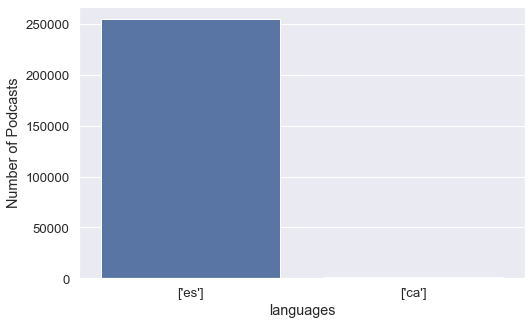

In [124]:
plot_count(podcasts_prep, 'languages')

In [127]:
counts

[254428, 1617]

Text(1, 2017, '1617')

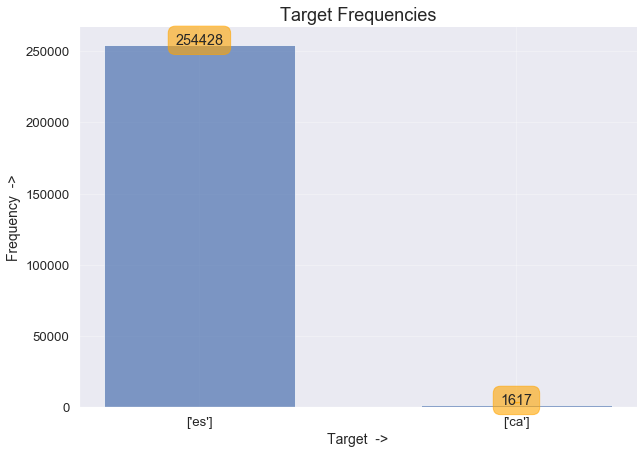

In [131]:
from matplotlib.pyplot import figure
from SWMat.SWMat import SWMat


figure(figsize=(10, 7))
plt.bar(labels, counts, alpha=0.7, width=0.6)


plt.grid(True, alpha=0.3)
plt.xlabel("Target  ->", fontsize=14)
plt.ylabel("Frequency  ->", fontsize=14)
plt.title("Target Frequencies", fontsize=18)
# Remove top and left spines:
ax = plt.gca() # Get current axis (gca)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Adding annotations:
plt.annotate(str(counts[0]), xy=(0, counts[0]), 
             xytext=(0,counts[0]+400), ha = 'center',
             bbox={'boxstyle': 'round', 'pad': 0.5, 'facecolor': 
                   'orange', 'edgecolor': 'orange', 'alpha': 0.6},
             arrowprops={'arrowstyle':"wedge,tail_width=0.5", 
                         'alpha':0.6, 'color': 'orange'})
plt.annotate(str(counts[1]), xy=(1, counts[1]), 
             xytext=(1, counts[1]+400), ha = 'center',
             bbox={'boxstyle': 'round', 'pad': 0.5, 'facecolor': 
                   'orange', 'edgecolor': 'orange', 'alpha': 0.6},
             arrowprops={'arrowstyle':"wedge,tail_width=0.5", 
                         'alpha':0.6, 'color': 'orange'})
# plt.annotate(str(counts[2]), xy=(2, counts[2]), 
#              xytext=(2, counts[2]+400), ha = 'center',
#              bbox={'boxstyle': 'round', 'pad': 0.5, 'facecolor': 
#                    'orange', 'edgecolor': 'orange', 'alpha': 0.6},
#              arrowprops={'arrowstyle':"wedge,tail_width=0.5", 
#                          'alpha':0.6, 'color': 'orange'})
# plt.annotate(str(counts[3]), xy=(3, counts[3]), 
#              xytext=(3, counts[3]+400), ha = 'center',
#              bbox={'boxstyle': 'round', 'pad': 0.5, 'facecolor': 
#                    'orange', 'edgecolor': 'orange', 'alpha': 0.6},
#              arrowprops={'arrowstyle':"wedge,tail_width=0.5", 
#                          'alpha':0.6, 'color': 'orange'})
# plt.annotate(str(counts[4]), xy=(4, counts[4]), 
#              xytext=(4, counts[4]+400), ha = 'center',
#              bbox={'boxstyle': 'round', 'pad': 0.5, 'facecolor': 
#                    'orange', 'edgecolor': 'orange', 'alpha': 0.6},
#              arrowprops={'arrowstyle':"wedge,tail_width=0.5", 
#                          'alpha':0.6, 'color': 'orange'})
# plt.xticks(ticks=[0, 1, 2, 3, 4], labels=["0 - 1", "1 - 2", "2 - 3",      
#            "3 - 4", "4 - 5"], fontsize=12)
# plt.ylim([0, 9500]);

``` python
# workclass
pipeline = [
        {'$match': {'work.workclass': 'Never_worked'}},
        {'$group': {'_id': '$race', 'count': {'$sum': 1}}},
        {"$sort": SON([("count", pymongo.DESCENDING)])}
    ]
```


In [ ]:
figure(figsize=(10, 7))
sns.barplot(np.sort(data.unique()),data.value_counts().sort_index())
plt.xlabel("Target  ->")
plt.ylabel("Frequency  ->");

#### 5.1.2 Numerical Variables

In [22]:
podcasts_prep.distinct('languages')

['ca', 'es']

In [ ]:
podcasts_prep.distinct('media_type')

In [ ]:
podcasts_prep.distinct('explicit')

In [ ]:
podcasts_prep.distinct('date_precision')

In [ ]:
podcasts_prep.find_one({'release_date':None})

In [ ]:
# TODO:

# Try to "visualize" each of the variables
# Compare languages and comment
# Episode frequency: total days / total episodes
# Episode release dates -> compare most popular days, months
# Year increase of podcasts
#
# Plus: genres?

In [ ]:
### 5.2. 

## 6. Conclusions

## References

[1] https://finance.yahoo.com/news/spotifys-podcast-subscriptions-expand-global-173408899.html?guccounter=1


[2] https://www.sec.gov/Archives/edgar/data/1639920/000119312521308632/d174858dex991.htm

[3] https://www.podchaser.com/articles/inside-podchaser/podchaser-raises-4m

[4] https://developer.spotify.com/documentation/web-api

[5] https://developer.spotify.com/community/news/2020/03/20/introducing-podcasts-api/

[6] https://podcasts.apple.com/es/genre/podcasts/id26

[7] https://developer.apple.com/support/enrollment/

In [ ]:
import pandas as pd
import sqlite3
import sqlalchemy 

try:
    conn = sqlite3.connect("podcastindex_feeds.db")    
except Exception as e:
    print(e)

#Now in order to read in pandas dataframe we need to know table name
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(f"Table Name : {cursor.fetchall()}")

df = pd.read_sql_query('SELECT * FROM podcasts', conn)
conn.close()

In [ ]:
df.head()   # language

rslt_df = df[df['language']=='ca']

In [ ]:
len(rslt_df)

In [ ]:
rslt_df = df[df['language']=='ca']
print(len(rslt_df))

In [ ]:
rslt_df = df[df['language']=='es']
print(len(rslt_df))

10.048.969 catalan speakers
https://www.plataforma-llengua.cat/media/upload/pdf/informecat2018_1528713023.pdf

A total of 580 million people speak Spanish in the world, 7.6% of the world’s population.
https://blogs.cervantes.es/londres/2019/10/15/spanish-a-language-spoken-by-580-million-people-and-only-483-million-of-them-native/

Spanish 2nd number of native spakers
https://www.babbel.com/en/magazine/the-10-most-spoken-languages-in-the-world

Spotify now offers podcasts
https://www.theverge.com/2015/5/20/8629335/spotify-adds-podcasts-videoshttps://www.theverge.com/2015/5/20/8629335/spotify-adds-podcasts-videos

[Test](#1.-Introduction)

